In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import os

# --- GPU Info ---
print("CUDA disponibile:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nome GPU:", torch.cuda.get_device_name(0))
else:
    print("Verrà usata solo la CPU.")

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import pickle

# --- Define Paths ---
DATASET_DIR = 'dataset'
CIFAR10_TAR_PATH = os.path.join(DATASET_DIR, 'cifar-10-python.tar.gz')
EXTRACTED_DIR = os.path.join(DATASET_DIR, 'cifar-10-batches-py')

# --- Extract CIFAR-10 if not already extracted ---
if not os.path.exists(EXTRACTED_DIR):
    print("Estrazione del dataset CIFAR-10...")
    with tarfile.open(CIFAR10_TAR_PATH, 'r:gz') as tar:
        tar.extractall(path=DATASET_DIR)
    print("Estrazione completata.")

# --- Funzione per caricare i batch di CIFAR-10 ---
def load_cifar10_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        data = dict[b'data']
        labels = dict[b'labels']
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # (N, 32, 32, 3)
        labels = np.array(labels)
        return data, labels

# --- Carica tutti i batch di training ---
train_data = []
train_labels = []
for i in range(1, 6):
    batch_file = os.path.join(EXTRACTED_DIR, f'data_batch_{i}')
    data, labels = load_cifar10_batch(batch_file)
    train_data.append(data)
    train_labels.append(labels)
full_train_data_raw_np = np.concatenate(train_data)
full_train_labels_np = np.concatenate(train_labels)

# --- Carica il batch di test ---
test_batch_file = os.path.join(EXTRACTED_DIR, 'test_batch')
test_data_raw_np, test_labels_raw_np = load_cifar10_batch(test_batch_file)

# --- Define train/validation split sizes ---
TRAIN_SIZE = int(full_train_data_raw_np.shape[0] * 0.9)

print(f"Full raw train data shape: {full_train_data_raw_np.shape}, dtype: {full_train_data_raw_np.dtype}")
print(f"Full raw train labels shape: {full_train_labels_np.shape}, dtype: {full_train_labels_np.dtype}")

# --- Split Raw Data using Slicing ---
train_data_raw = full_train_data_raw_np[:TRAIN_SIZE]
val_data_raw = full_train_data_raw_np[TRAIN_SIZE:]
train_labels_raw = full_train_labels_np[:TRAIN_SIZE]
val_labels_raw = full_train_labels_np[TRAIN_SIZE:]

print(f"Raw train subset shape: {train_data_raw.shape}")
print(f"Raw validation subset shape: {val_data_raw.shape}")
print(f"Raw train labels subset shape: {train_labels_raw.shape}")
print(f"Raw validation labels subset shape: {val_labels_raw.shape}")

# --- Calculate Channel-wise Mean/Std from Training Subset ---
print("Calculating channel-wise mean and std from training subset...")
train_data_for_stats = train_data_raw / 255.0
calculated_mean_np = np.mean(train_data_for_stats, axis=(0, 1, 2))
calculated_std_np = np.std(train_data_for_stats, axis=(0, 1, 2))
calculated_std_np[calculated_std_np == 0] = 1e-6

print(f"Calculated Mean (per channel): {calculated_mean_np}")
print(f"Calculated Std Dev (per channel): {calculated_std_np}")

Estrazione del dataset CIFAR-10...


C:\Users\xolor\AppData\Local\Temp\ipykernel_15428\857989947.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATASET_DIR)


Estrazione completata.
Full raw train data shape: (50000, 32, 32, 3), dtype: uint8
Full raw train labels shape: (50000,), dtype: int64
Raw train subset shape: (45000, 32, 32, 3)
Raw validation subset shape: (5000, 32, 32, 3)
Raw train labels subset shape: (45000,)
Raw validation labels subset shape: (5000,)
Calculating channel-wise mean and std from training subset...
Calculated Mean (per channel): [0.49154913 0.4821251  0.44642678]
Calculated Std Dev (per channel): [0.24715214 0.24367544 0.26173454]



Displaying sample images from the raw training subset...


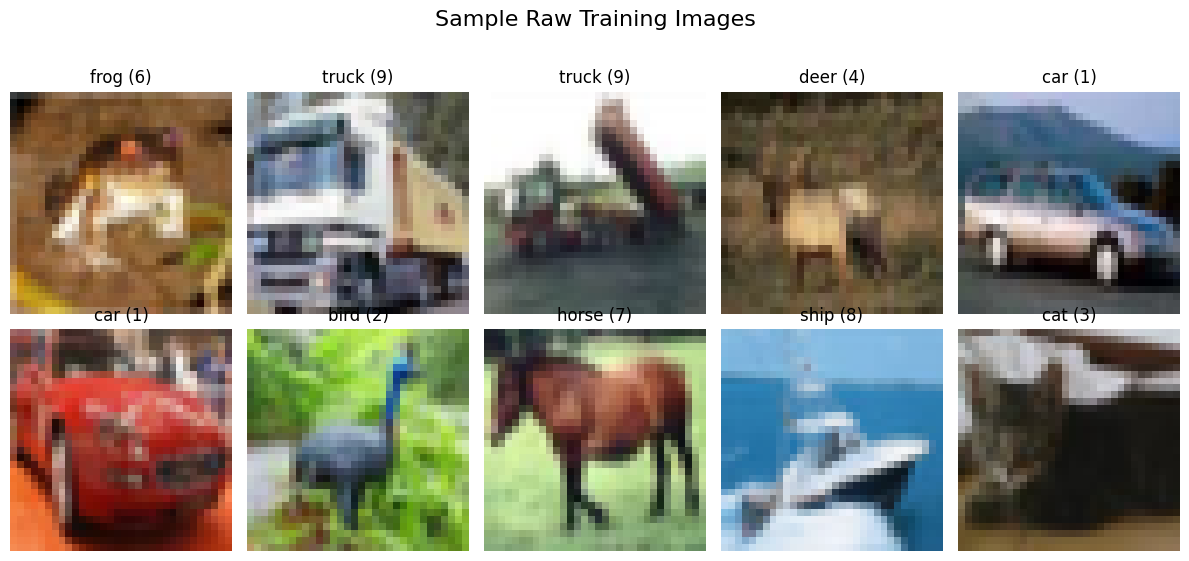

In [11]:
# This cell assumes train_data_raw and train_labels_raw are populated from the previous cell.
# If the previous cell's TODOs are not completed, this cell might error or show nothing.
if 'train_data_raw' in locals() and len(train_data_raw) > 0:
    print("\nDisplaying sample images from the raw training subset...")

    # Define CIFAR-10 class names
    cifar10_classes = ('plane', 'car', 'bird', 'cat',
                       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Create a figure to display images
    num_images_to_show = min(10, len(train_data_raw)) # Show up to 10 images, or fewer if dataset is small
    num_cols = 5
    num_rows = (num_images_to_show + num_cols - 1) // num_cols # Calculate rows needed
    fig_samples, axes_samples = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))
    if num_images_to_show == 0 :
        axes_flat = []
    elif num_rows == 1 and num_cols == 1: # Single image
        axes_flat = [axes_samples]
    elif num_rows == 1 or num_cols == 1: # Single row or column
        axes_flat = axes_samples.flatten()
    else: # Multiple rows and columns
        axes_flat = axes_samples.flatten()


    fig_samples.suptitle("Sample Raw Training Images", fontsize=16)


    for i in range(num_images_to_show):
        # Get raw image (uint8, HxWxC) and label
        img_raw = train_data_raw[i]
        label_index = train_labels_raw[i]

        # Get the corresponding subplot axis
        ax = axes_flat[i]

        # Display the uint8 image directly (matplotlib handles HxWxC)
        ax.imshow(img_raw)
        ax.set_title(f"{cifar10_classes[label_index]} ({label_index})") # Show class name and index
        ax.axis('off') # Hide axis ticks and labels

    # Hide any unused subplots
    for j in range(num_images_to_show, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
else:
    print("`train_data_raw` is not defined or is empty. Cannot display sample images. Please complete the TODOs in the previous cell.")

In [16]:
# --- Define Custom Dataset Class ---
class CustomDataset(Dataset): # Dataset from torch.utils.data
    def __init__(self, data_np, labels_np, transform=None):

        self.data_np = data_np
        self.labels_np = labels_np
        self.transform = transform

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.data_np)

    def __getitem__(self, idx):

        image_raw = self.data_np[idx] # This is HxWxC
        label = self.labels_np[idx]

        # Apply the transform pipeline (if it exists) directly to the raw image
        # The pipeline should handle conversion to tensor, normalization, and flattening
        image_final = image_raw # Default if no transform
        if self.transform:
            image_final = self.transform(image_raw) # Pipeline output should be the final flattened tensor


        # Convert label to a LongTensor
        label_tensor = torch.tensor(label).long()

        return image_final, label_tensor

# Use the calculated mean/std from Section 2
# Convert numpy arrays to lists or tuples for transforms.Normalize
mean_list = calculated_mean_np.tolist()
std_list = calculated_std_np.tolist()

transform_pipeline = transforms.Compose([
    transforms.ToTensor(), # Converts HWC uint8 [0,255] -> CHW float32 [0,1]
    transforms.Normalize(mean=mean_list, std=std_list), # Operates on CHW tensor
    nn.Flatten(0, -1) # Flattens the CHW tensor. Start_dim=0, end_dim=-1 flattens all dimensions.
])

# Instantiate the custom dataset, passing the transform pipeline
train_dataset = CustomDataset(train_data_raw, train_labels_raw, transform=transform_pipeline)
print(f"Custom training dataset created. Size: {len(train_dataset)}")

val_dataset = CustomDataset(val_data_raw, val_labels_raw, transform=transform_pipeline)
print(f"Custom validation dataset created. Size: {len(val_dataset)}")

test_data_raw_loaded = test_data_raw_np
test_labels_raw_loaded = test_labels_raw_np
print(f"Raw test data shape: {test_data_raw_loaded.shape}")

# Crea il dataset custom per il test set
test_dataset = CustomDataset(test_data_raw_loaded, test_labels_raw_loaded, transform=transform_pipeline)
print(f"Custom test dataset created. Size: {len(test_dataset)}")

# --- Create DataLoaders ---
BATCH_SIZE = 64
INPUT_SIZE = np.prod(train_data_raw.shape[1:]) # 32*32*3
NUM_CLASSES = 10

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("DataLoaders created using custom datasets.")

Custom training dataset created. Size: 45000
Custom validation dataset created. Size: 5000
Raw test data shape: (10000, 32, 32, 3)
Custom test dataset created. Size: 10000
DataLoaders created using custom datasets.


In [17]:
# Definition of SimpleMLP (remains the same as before)
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=INPUT_SIZE, num_classes=NUM_CLASSES, hidden_size=512):
        super().__init__()
        # Ensure input_dim matches the flattened size (3072)
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Input x is expected to be flattened (batch_size, 3072) by the transform pipeline
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [18]:
# Definition of train_evaluate function (remains the same as before)
# It will now use the DataLoaders created from the CustomDataset
def train_evaluate(hidden_size_param=512, lr_param=0.001, epochs_param=10):
    # Initialization
    model = SimpleMLP(input_dim=INPUT_SIZE, num_classes=NUM_CLASSES, hidden_size=hidden_size_param) # Corrected instantiation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Training on device: {device}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr_param)

    print(f"Starting training with: Hidden Size={hidden_size_param}, LR={lr_param}, Epochs={epochs_param}")

    # Training Loop
    for epoch in range(epochs_param):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        # Assumes train_loader is globally accessible and uses the custom dataset
        for inputs, labels in train_loader:
            # Data is already transformed (ToTensor, Normalize, Flatten) by the Dataset's __getitem__
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Compute training accuracy
            predicted_train = torch.argmax(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted_train == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
        epoch_train_acc = train_correct / train_total if train_total > 0 else 0


        # Validation Loop (per epoch)
        model.eval()  # Set model to evaluation mode
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        # Assumes val_loader is globally accessible and uses the custom dataset
        with torch.no_grad():  # No gradients needed for validation
            for inputs_val, labels_val in val_loader:
                # Data is already transformed
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

                predicted_val = torch.argmax(outputs_val.data, 1)
                val_total += labels_val.size(0)
                val_correct += (predicted_val == labels_val).sum().item()

        epoch_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        epoch_val_acc = val_correct / val_total if val_total > 0 else 0


        print(f"Epoch [{epoch+1}/{epochs_param}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2%}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2%}")

    # Final evaluation on test set
    print("\nFinal evaluation on the test set...")
    model.eval()  # Ensure model is in evaluation mode
    all_labels = []
    all_preds = []

    # Assumes test_loader is globally accessible and uses the custom dataset
    with torch.no_grad():
        for inputs_test, labels_test in test_loader:
            # Data is already transformed
            inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
            outputs_test = model(inputs_test)
            preds = torch.argmax(outputs_test, 1)

            all_labels.extend(labels_test.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Confusion matrix and accuracy
    cm = confusion_matrix(all_labels, all_preds)
    test_accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0


    print(f"\nTest Accuracy: {test_accuracy:.2%}")

    return test_accuracy, cm

In [ ]:
# Configurations to test (remains the same)
hyperparams_to_test = [
    {'hidden_size_param': 256, 'lr_param': 0.01},
    {'hidden_size_param': 512, 'lr_param': 0.001},
    {'hidden_size_param': 1024, 'lr_param': 0.0001}
]

# Run experiments (remains the same)
experiment_results = []
epochs_for_experiment = 20 # Or your desired number of epochs

print("\n--- Starting Hyperparameter Experimentation ---")
for config_idx, config in enumerate(hyperparams_to_test):
    print(f"\n--- Experiment {config_idx+1}/{len(hyperparams_to_test)} ---")
    print(f"Testing configuration: {config}")
    # train_evaluate function needs to be defined and accessible
    # It will use the DataLoaders based on the custom dataset
    acc, cm = train_evaluate(**config, epochs_param=epochs_for_experiment)
    experiment_results.append({'config': config, 'accuracy': acc, 'cm': cm})
    print(f"--- End of Experiment {config_idx+1} ---")
    print(f"Test Set Accuracy for {config}: {acc:.2%}")
print("\n--- Hyperparameter Experimentation Finished ---")


--- Starting Hyperparameter Experimentation ---

--- Experiment 1/3 ---
Testing configuration: {'hidden_size_param': 256, 'lr_param': 0.01}
Training on device: cpu
Starting training with: Hidden Size=256, LR=0.01, Epochs=20


c:\Users\xolor\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
